In [1]:

import torch
import torch.optim as optim
import torch.nn as nn
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
import numpy as np
import random
from data_gen import Datagen

from generator import Generator
from evaluation import evaluate_model, bin_plot
from recognition import Recognition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=None
print("Using device: ", device)

import torch
print(torch.__version__)
 

Using device:  cuda
1.12.0+cu116


In [2]:
gen = Datagen(device)

x, y, x_1 = gen.get_generated_data(seq_len=2)

print("x", x.size())
print("y", y)


x torch.Size([7652, 2])
y tensor([[1.0000],
        [0.4600],
        [1.0000],
        ...,
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')


In [3]:
import random

# Hyperparameters
sequence_length = [2*i for i in range(4,16)]  # 2-20 increments of two
hidden_layers = [1,2] # 1 and 2
hidden_1 = [2**i for i in range(2,7)] # 2^4 to 2^9
hidden_2 =[2**i for i in range(5,10)] # 2^2 to 2^5
variance = [0.001, 0.01, 0.005, 0.05]
lr = [0.001, 0.01, 0.1, 0.005] # stop at 0.005
data_probability = [i/5 for i in range(1,6)]
regularization = [1/i for i in range(1,10)]
for i in range(3):
    regularization.append(0)

epochs = 400 
optimizer = [optim.Adam, optim.SGD]

options = []

for seq_len in sequence_length:
    for layers in hidden_layers:
        for h1 in hidden_1:
            for h2 in hidden_2:
                for l in lr:
                    for v in variance:
                        for p in data_probability:
                            for r in regularization:
                                entry = {}
                                entry["seq_len"] = seq_len
                                entry["layers"] = layers
                                entry["latent"] = h1
                                entry["hidden"] = h2
                                entry["l"] = l
                                entry["variance"] = v
                                entry["data_prob"] = p
                                options.append(entry)
                
                                         
random.shuffle(options)    


torch.Size([7652, 14]) torch.Size([7652, 2])
[0, 2.0424812480457146, 3132.4111810922623]
[10, 2.1047210977376287, 3227.951219201088]
[20, 2.007883914768229, 3071.4782741069794]
[30, 1.9745747971472478, 3027.499056458473]
[40, 1.9392719449324645, 2970.5322276353836]
[50, 2.1275154130421483, 3248.401522397995]
[60, 2.034497637583755, 3123.2252177000046]
[70, 2.024315467157812, 3101.6190433502197]
[80, 1.984951484841404, 3041.374340057373]
[90, 2.2594104434117948, 3457.756618499756]
[100, 2.318092752685746, 3532.0589258670807]
[110, 2.2915451343003514, 3508.24565577507]
[120, 2.278771048893194, 3486.8948707580566]
[130, 2.49137735522447, 3818.077083349228]
[140, 2.405131537048997, 3679.536860227585]
[150, 2.2543559914780658, 3454.350702047348]
[160, 2.3649647220307792, 3626.6488120555878]
[170, 2.2317244287570523, 3419.6003313064575]
[180, 2.2589005494864742, 3460.3560979366302]
[190, 2.262225378431166, 3468.5657408237457]
[200, 2.3155404419562835, 3551.544466495514]
[210, 2.5613749084833

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

torch.Size([7652, 18]) torch.Size([7652, 2])
[0, 4.451630464733114, 6817.178105592728]
[10, 4.903078829806405, 7698.331997871399]
[20, 4.497392083116985, 6884.5437734127045]
[30, 4.323609071674297, 6625.692431926727]
[40, 4.2390600036703265, 6499.165828943253]
[50, 4.191444678966432, 6427.858602762222]
[60, 153.3186294848863, 234884.14045405388]
[70, 153.31858511942173, 234884.07241773605]
[80, 153.3185996262274, 234884.09480714798]
[90, 153.37782133497083, 234910.82255220413]
[100, 153.31285272565896, 234875.2897119522]
[110, 153.27606262628467, 234936.92844700813]
[120, 153.34912232132555, 234840.85540771484]
[130, 153.3125059834971, 235074.75965881348]
[140, 153.2472264735568, 234874.75062060356]
[150, 153.2473273048513, 234973.8582520485]
[160, 153.3125527717426, 234820.83072280884]
[170, 153.3124613575151, 234874.69078063965]
[180, 153.3125124400963, 234874.76904296875]
[190, 153.41819547906556, 234874.67554068565]
[200, 153.37781750595602, 234874.81656312943]
[210, 153.3778305179

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [240, 153.31278966550104, 234875.19393634796] 
Best loss: [240, 153.31278966550104, 234875.19393634796]
torch.Size([7652, 24]) torch.Size([7652, 2])
[0, 1.969391164362586, 3024.856282711029]
[10, 1.729560675259981, 2647.011233687401]
[20, 1.8525880326178927, 2834.880110144615]
[30, 1.7907503254264203, 2737.409274458885]
[40, 1.7139445590755025, 2622.799025297165]
[50, 1.744308642556711, 2676.851385951042]
[60, 1.9527986453500803, 2974.947196125984]
[70, 1.841762120278635, 2815.594883918762]
[80, 1.8373127454410334, 2813.8970350027084]
[90, 1.9086101371065443, 2923.5705511569977]
[100, 2.3787882703091396, 3595.8212965726852]
[110, 1.8464653276432277, 2822.3667464256287]
[120, 1.7562367487358361, 2689.858782529831]
[130, 1.7577783777414975, 2692.657661318779]
[140, 1.723300213446505, 2640.8626457452774]
[150, 1.8687844844462043, 2861.4410548210144]
[160, 1.7352981365847526, 2657.770178794861]
[170, 1.724692882352336, 2638.961353778839]
[180, 1.85032

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

torch.Size([7652, 16]) torch.Size([7652, 2])
[0, 4.648785327184294, 7132.950548648834]
[10, 9.19868046091991, 14009.24840092659]
[20, 348.6327679985186, 533926.855178833]
[30, 153.60635055761114, 235324.92888355255]
[40, 153.60627490857874, 235324.81302261353]
[50, 153.60647628170392, 235325.12187957764]
[60, 153.6062867635224, 235324.83130049706]
[70, 153.60638198388776, 235324.97687149048]
[80, 153.60639629911816, 235324.99928331375]
[90, 153.60641265584655, 235325.0244731903]
[100, 153.60644342009144, 235325.0708551407]
[110, 153.6064788820538, 235325.12546420097]
[120, 153.60636321931844, 235324.94858551025]
[130, 153.60636865750305, 235324.9566617012]
[140, 153.60644537475028, 235325.07513046265]
[150, 153.60636635315325, 235324.9534187317]
[160, 153.60633582172443, 235324.90641593933]
[170, 153.60647379091452, 235325.11780166626]
[180, 153.606469395889, 235325.1113357544]
[190, 153.60633450668723, 235324.90429711342]
[200, 153.60634218074634, 235324.91591000557]
Initial
Initial_d

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [200, 153.60634218074634, 235324.91591000557] 
Best loss: [200, 153.60634218074634, 235324.91591000557]
torch.Size([7652, 12]) torch.Size([7652, 2])
[0, 152.92188396372933, 234276.3261756897]
[10, 153.15677092599807, 234636.17352199554]
[20, 153.40657954505468, 235018.87975883484]
[30, 153.40672030259051, 235019.09540843964]
[40, 153.40661294653273, 235018.93070101738]
[50, 153.4069925117119, 235019.51256251335]
[60, 153.4069620735029, 235019.46596574783]
[70, 153.40650666475918, 235018.76811528206]
[80, 153.40653229071017, 235018.80730485916]
[90, 153.4069461333845, 235019.44123530388]
[100, 153.40641735116745, 235018.63204574585]
[110, 153.40657152519526, 235018.86756896973]
[120, 153.40678135844496, 235019.18918418884]
[130, 153.40652510951767, 235018.79600524902]
[140, 153.4066834418643, 235019.03762626648]
[150, 153.40678410928493, 235019.19263410568]
[160, 153.40667538854535, 235019.02633285522]
Initial
Initial_done
HERE
[500.0, 500.0, 500.0

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [160, 153.40667538854535, 235019.02633285522] 
Best loss: [160, 153.40667538854535, 235019.02633285522]
torch.Size([7652, 18]) torch.Size([7652, 2])
[0, 152.59370233246926, 233773.55192184448]
[10, 152.59368704741834, 233773.52879309654]
[20, 152.59396792617542, 233773.95960235596]
[30, 152.59366841232963, 233773.49996948242]
[40, 152.5938026081411, 233773.70514178276]
[50, 152.59366839112562, 233773.4999809265]
[60, 152.59375723986338, 233773.63624972105]
[70, 152.59394567916974, 233773.92473602295]
[80, 152.59366890531297, 233773.50074386597]
[90, 152.5938963122841, 233773.84928148985]
[100, 152.59366838762406, 233773.4999126196]
[110, 152.59366838241058, 233773.49991226196]
[120, 152.59371729370196, 233773.5752683878]
[130, 152.59403456844797, 233774.0610218048]
[140, 152.59366838027074, 233773.49997711182]
Initial
Initial_done
HERE
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [140, 152.59366838027074, 233773.49997711182] 
Best loss: [140, 152.59366838027074, 233773.49997711182]
torch.Size([7652, 16]) torch.Size([7652, 2])
[0, 2.1176405534264937, 3246.9159862995148]
[10, 2.276132462696992, 3494.953942298889]
[20, 2.1252261912231347, 3233.1693964004517]
[30, 2.069629250245057, 3170.3259176015854]
[40, 2.2558375601668894, 3446.6752696037292]
[50, 2.905792500580571, 4454.0909469127655]
[60, 2.5716862014006074, 3940.7686307430267]
[70, 2.4391082218670657, 3734.6025519371033]
[80, 2.5915110599901285, 3969.105702638626]
[90, 2.4406699728094257, 3736.6656391620636]
[100, 2.3943879621458426, 3667.7356476783752]
[110, 2.662507982851631, 4077.910117149353]
[120, 2.8433721305184827, 4353.920775413513]
[130, 2.6414886697465385, 4056.699159383774]
[140, 2.602037760669818, 3983.675786972046]
[150, 2.968849019033168, 4428.147178888321]
[160, 3.013476675857763, 4615.802988767624]
[170, 2.8716879857426836, 4397.581599473953]
[180, 3.156

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [390, 12.936236244735767, 19817.419419288635] 
Best loss: [390, 12.936236244735767, 19817.419419288635]
torch.Size([7652, 22]) torch.Size([7652, 2])
[0, 2.0847726089991725, 3200.561780691147]
[10, 1.9450174730378094, 2970.5105336904526]
[20, 1.8851009115537838, 2895.1661385297775]
[30, 1.8611770381192936, 2850.1577793359756]
[40, 1.8701147124287976, 2860.970524907112]
[50, 1.8579009523902177, 2842.282561302185]
[60, 1.8495980647463088, 2845.456446170807]
[70, 1.8602428417604213, 2843.5890778303146]
[80, 1.8729727024664766, 2853.3378480672836]
[90, 1.8672329567898036, 2876.210104703903]
[100, 1.8600265975098074, 2837.6577558517456]
[110, 1.8446360814042253, 2825.555677175522]
[120, 1.8539268556525128, 2844.3665318489075]
[130, 1.8501469069610377, 2851.028899550438]
[140, 1.8537904887068677, 2838.7381073236465]
[150, 1.8746595489294038, 2873.5525925159454]
[160, 1.8529656376913384, 2836.9302963018417]
[170, 1.86335525056712, 2841.785747528076]
[180,

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [390, 1.8531238051525296, 2820.238300681114] 
Best loss: [390, 1.8531238051525296, 2820.238300681114]
torch.Size([7652, 16]) torch.Size([7652, 2])
[0, 1.9391137523377222, 2953.1722532510757]
[10, 1.7740293625285046, 2717.2760339975357]
[20, 1.7301931345431674, 2644.222815990448]
[30, 1.7078033089637756, 2612.0612775087357]
[40, 1.701432341772956, 2608.819077372551]
[50, 1.6803567974436688, 2574.491532087326]
[60, 1.6863660788255945, 2589.3183238506317]
[70, 1.863328049450568, 2873.3380229473114]
[80, 1.6799009111624785, 2576.9452245235443]
[90, 1.7199334106152737, 2637.7073106765747]
[100, 1.721580829072559, 2626.2064059972763]
[110, 1.7014339040994022, 2598.54498398304]
[120, 1.707780372769652, 2612.6071498394012]
[130, 1.6802223597898807, 2577.7728716135025]
[140, 1.7025385705982736, 2608.9813364744186]
[150, 1.6897811007250694, 2587.173311829567]
[160, 1.6845541587853246, 2583.390977025032]
[170, 1.6812096993699086, 2578.3223884105682]
[180, 1.

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [390, 2.0174794974432912, 3091.480537176132] 
Best loss: [390, 2.0174794974432912, 3091.480537176132]
torch.Size([7652, 28]) torch.Size([7652, 2])
[0, 2.259829937166707, 3460.749945282936]
[10, 2.2967478425944754, 3527.034146785736]
[20, 2.0252594513619226, 3102.7103341817856]
[30, 2.0381449292907514, 3124.538114786148]
[40, 2.0074992616400706, 3068.643681406975]
[50, 2.0178733208938926, 3088.0574157238007]
[60, 2.0345592069252354, 3098.980324983597]
[70, 2.0249475940244936, 3107.8929187059402]
[80, 2.2917214020425285, 3524.207382440567]
[90, 2.0712868276370724, 3177.7836698293686]
[100, 2.088625774837972, 3201.665901184082]
[110, 2.0611075619649015, 3162.7748903036118]
[120, 2.063201345367158, 3162.4244241714478]
[130, 2.248226590240593, 3437.8160910606384]
[140, 2.0351049135154593, 3109.810755252838]
[150, 2.0294244506496053, 3112.6057744026184]
[160, 2.0453269691753637, 3130.9607647657394]
[170, 2.0343562646260773, 3123.982113003731]
[180, 2.02

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [190, 153.67668248467905, 235432.6778330803] 
Best loss: [190, 153.67668248467905, 235432.6778330803]
torch.Size([7652, 24]) torch.Size([7652, 2])
[0, 1.8527830561365222, 2833.4583793878555]
[10, 1.7004777563458635, 2602.5598706007004]
[20, 1.7023451445774995, 2659.582864522934]
[30, 1.7026371526344637, 2605.747950911522]
[40, 1.690588325651134, 2583.5716475248337]
[50, 1.6575945192466517, 2544.606945037842]
[60, 1.6521671303881056, 2529.8582530021667]
[70, 1.6430144674939835, 2515.0928407907486]
[80, 1.657655185180918, 2542.0622203350067]
[90, 1.6402435533060418, 2513.50533080101]
[100, 1.6394189997690465, 2512.42515873909]
[110, 1.6363028659833008, 2505.0569734573364]
[120, 1.6396110120081093, 2513.064348101616]
[130, 1.6408691329993406, 2512.9325993061066]
[140, 1.6507405531313026, 2524.985792517662]
[150, 1.6355248797033226, 2507.6600291728973]
[160, 1.6338736614110265, 2504.7246146202087]
[170, 1.673439350280687, 2565.79319691658]
[180, 1.638

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [390, 1.9945187338338508, 3050.553685069084] 
Best loss: [390, 1.9945187338338508, 3050.553685069084]
torch.Size([7652, 30]) torch.Size([7652, 2])
[0, 1.8577308945027096, 2845.507281422615]
[10, 1.7370716524808898, 2656.4998203516006]
[20, 1.7586218559088347, 2697.328291416168]
[30, 1.7094329790097926, 2619.7091101408005]
[40, 2.070992978138961, 3183.134288907051]
[50, 1.905717772463283, 2913.3914635181427]
[60, 1.9167253269227926, 2932.1414408683777]
[70, 1.8232362627516217, 2794.3934092521667]
[80, 1.8668582556141886, 2861.9864975214005]
[90, 1.831480990268543, 2802.4839482307434]
[100, 1.947708378572688, 2988.7730629444122]
[110, 1.8848692218410752, 2895.748424053192]
[120, 1.8676963318577011, 2860.913570046425]
[130, 1.9288833360759148, 2958.634147167206]
[140, 1.8452319593871542, 2824.326017022133]
[150, 1.9026360021558817, 2920.989651441574]
[160, 1.8752495751524096, 2870.220794200897]
[170, 1.9120691219446864, 2923.399336338043]
[180, 1.898

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [390, 1.7732917648538287, 2708.327586889267] 
Best loss: [390, 1.7732917648538287, 2708.327586889267]
torch.Size([7652, 28]) torch.Size([7652, 2])
[0, 1.8782387165736902, 2871.7487663030624]
[10, 1.6779236242603073, 2569.5734102725983]
[20, 1.681711283349493, 2577.5602803230286]
[30, 1.6574653085933964, 2543.1256494522095]
[40, 1.6751225983660776, 2571.8719457387924]
[50, 1.6506174780992553, 2529.8846542835236]
[60, 1.6587756357056043, 2539.8231159448624]
[70, 1.7991045290122767, 2749.9438631534576]
[80, 1.65252075252894, 2531.0414838790894]
[90, 1.6642841925508982, 2559.3980972766876]
[100, 1.6478158230103026, 2522.2360590696335]
[110, 1.6405226648165103, 2513.704805254936]
[120, 1.6375115290478688, 2508.9894810914993]
[130, 1.6488874729713012, 2526.441978096962]
[140, 1.6382226798459694, 2511.2274119853973]
[150, 1.6330573298912447, 2501.2977336645126]
[160, 1.6404365129165799, 2512.222651362419]
[170, 1.635839880057477, 2508.0042536258698]
[180

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [160, 153.17182654189068, 234659.23828220367] 
Best loss: [160, 153.17182654189068, 234659.23828220367]
torch.Size([7652, 28]) torch.Size([7652, 2])
[0, 2.024909336946652, 3091.255468249321]
[10, 1.8969214420094502, 2901.2200487852097]
[20, 1.8006942869788984, 2757.821694254875]
[30, 1.7841390000933455, 2734.969559907913]
[40, 1.7951030188845591, 2746.125648021698]
[50, 1.7965796214793432, 2748.562849998474]
[60, 1.9246674771408498, 2937.1711312532425]
[70, 1.8271249468114918, 2793.6875706911087]
[80, 1.770872320970107, 2741.16468000412]
[90, 1.7775004057130988, 2710.1751235723495]
[100, 1.776717280750175, 2720.7562849521637]
[110, 1.8280743472569916, 2791.7376449108124]
[120, 1.7562594262022262, 2698.134544968605]
[130, 1.7659297429861662, 2710.9629940986633]
[140, 1.7722849884014529, 2693.3523906469345]
[150, 1.7674458741986099, 2708.467994570732]
[160, 1.7617944696864634, 2695.1144490242004]
[170, 1.7536316137400993, 2690.9115974903107]
[180, 1

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Old model still stands:
Current loss:  [160, 153.0749559723833, 234510.83247756958] 
Best loss: [160, 153.0749559723833, 234510.83247756958]
torch.Size([7652, 28]) torch.Size([7652, 2])
[0, 153.16454949866076, 234648.08957099915]
[10, 153.0788517507187, 234516.8009904623]
[20, 153.0487385574271, 234517.05503463745]
[30, 153.54641449809387, 234769.10725402832]
[40, 348.18471025113337, 533518.9758224487]
[50, 348.14423992864147, 533418.9756240845]
[60, 348.2499818627579, 533418.9723052979]
[70, 348.2499820221186, 533456.9727859497]
[80, 348.18470818940403, 533256.9727859497]
[90, 348.209512200119, 533518.972694397]
[100, 348.2499820420387, 533518.9725418091]
[110, 348.24998220139946, 533618.9726333618]
[120, 348.144238051173, 533518.9722137451]
[130, 348.2499819972185, 533518.9722824097]
[140, 348.2499821615593, 533518.9725952148]
[150, 348.249982096819, 533518.9724578857]
[160, 348.2095121478287, 533518.9724884033]
[170, 348.2499819225182, 533418.9726409912]
[180, 348.2499820146486, 533

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Old model still stands:
Current loss:  [390, 2.029085711850821, 3112.7801731824875] 
Best loss: [390, 2.029085711850821, 3112.7801731824875]
torch.Size([7652, 18]) torch.Size([7652, 2])
[0, 153.18725357704622, 234682.87188112736]
[10, 153.19532153002586, 234695.23264312744]
[20, 153.1881208567644, 234684.20092773438]
[30, 153.18815118969266, 234684.24765634537]
[40, 153.188150800784, 234684.24703800678]
[50, 153.18779914372894, 234683.70847833157]
[60, 153.18815079930556, 234684.2470626831]
[70, 153.1881508291857, 234684.247089386]
[80, 153.18816511476942, 234684.26914215088]
[90, 153.18815076514574, 234684.2470498085]
[100, 153.18815078327611, 234684.2470855713]
[110, 153.1881508183697, 234684.24708509445]
[120, 153.18815079837182, 234684.24711227417]
[130, 153.1881507893455, 234684.24710083008]
[140, 153.18815081494594, 234684.2470574379]
[150, 153.18815081673566, 234684.24703466892]
[160, 153.1881508158019, 234684.247043252]
Initial
Initial_done
HERE
[500.0, 500.0, 500.0, 500.0, 500

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

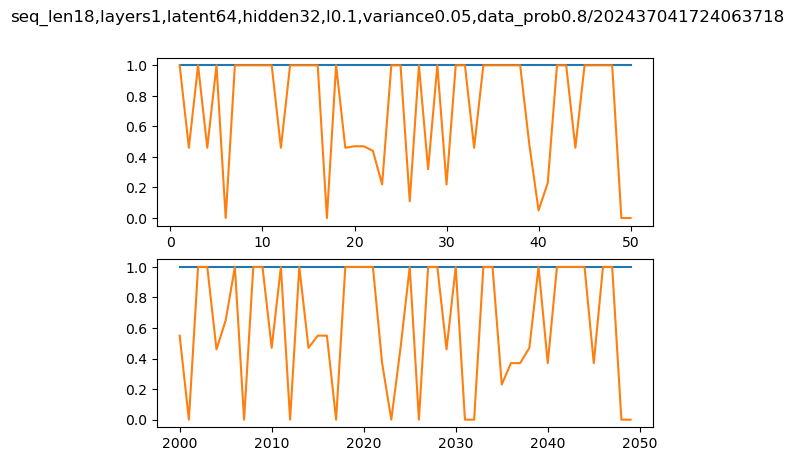

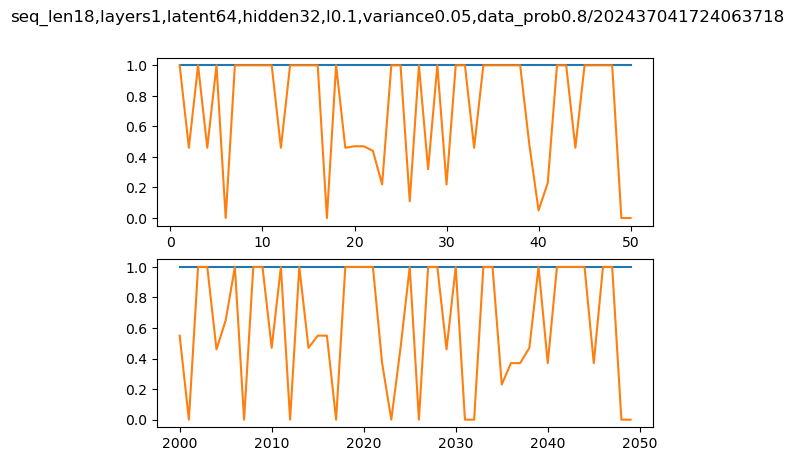

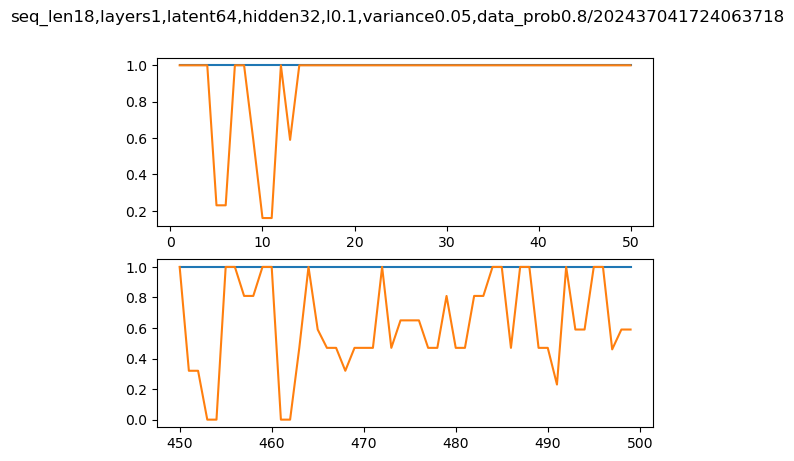

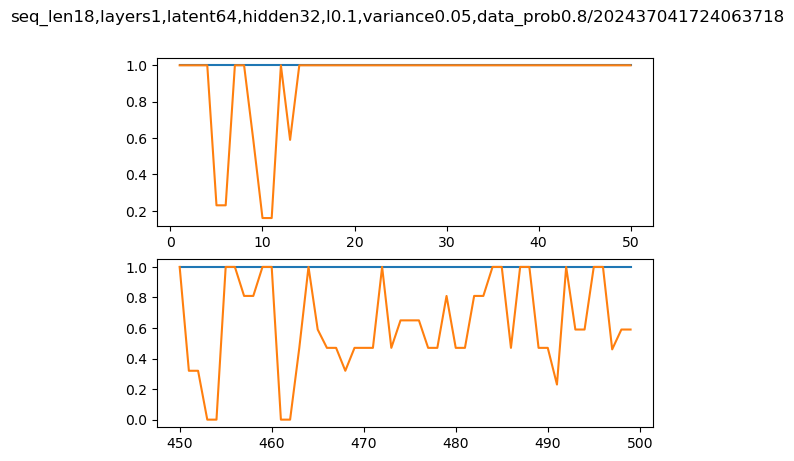

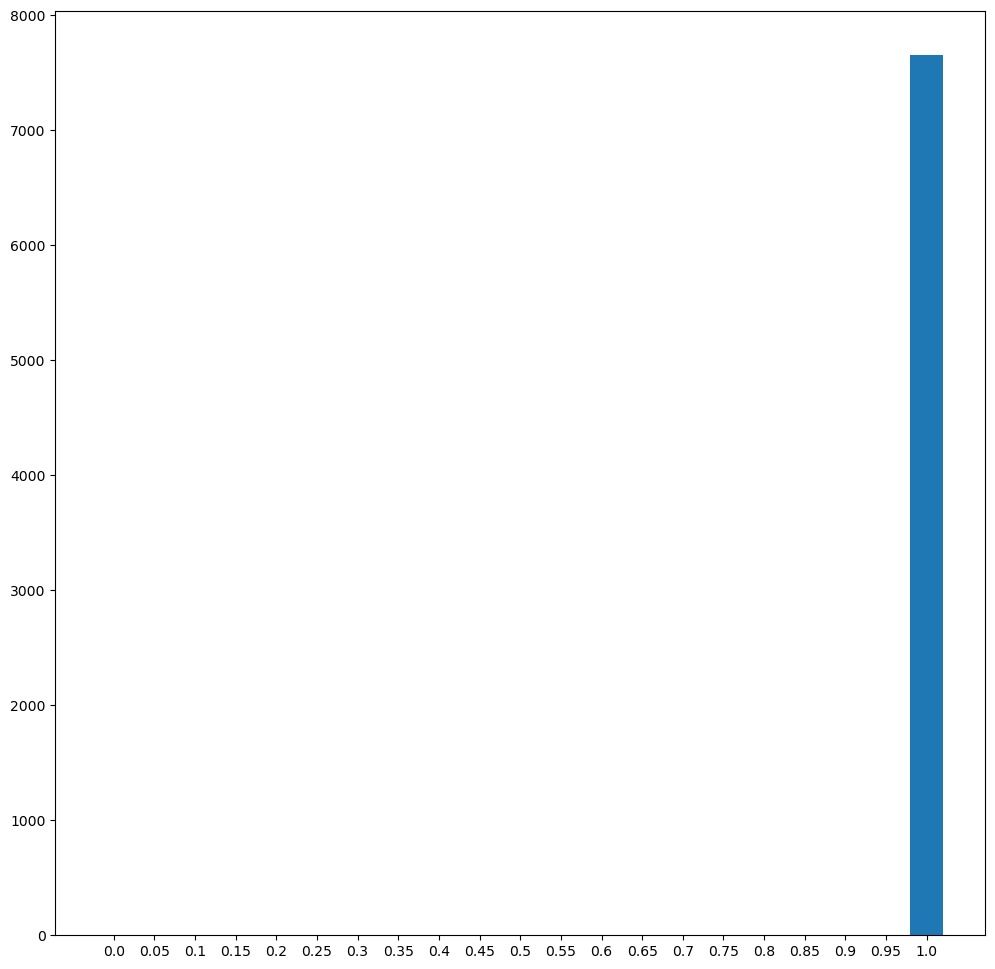

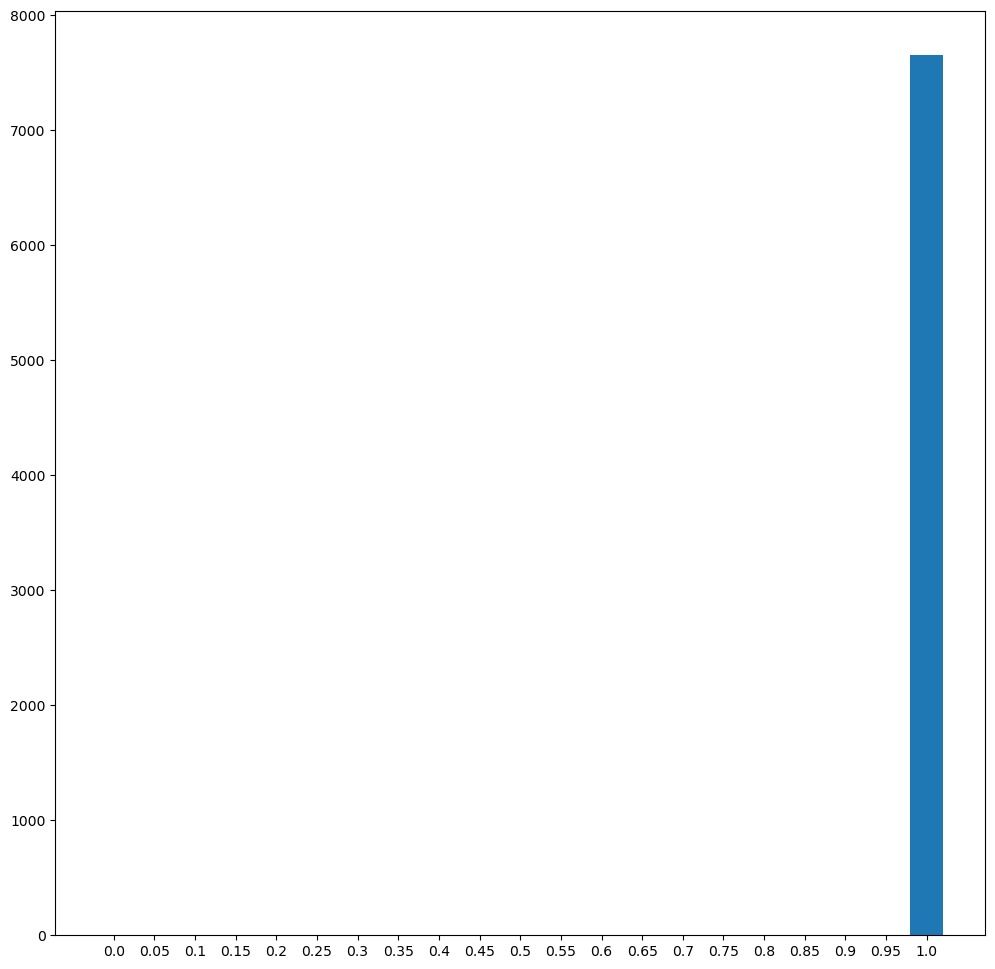

In [4]:
import torch.utils.data as data
from itertools import chain
import torch.nn.functional as F

def loss(y, y_hat, mean, R,g, device=None, seq_len=1):
    
    mse = nn.MSELoss().to(device)
    l = F.binary_cross_entropy(y_hat, y, reduction='sum')
    amount = mean[0].size()[0]*mean[0].size()[1]
    for m, r in zip(mean, R):
        
        C = r @ r.transpose(-2,-1) + 1e-6
        det = C.det() + 1e-6 
        l += 0.5 * torch.sum(m.pow(2).sum(-1) 
                             + C.diagonal(dim1=-2,dim2=-1).sum(-1)
                            -det.log()  -1)/amount
    
    #print(l, F.binary_cross_entropy(x_hat, x, reduction='sum'))
    return l 

best_model = None
best_score = 10000000000000000
batch_size = 10
best_history= [0,0,0,0,0,0]
history = []
history.append([1000,1000,1000])
for entry in options:

    x_d, y_d, x_d_1 = gen.get_generated_data(entry["seq_len"], entry["variance"], entry["data_prob"])
    x_t, y_t, x_t_1 = gen.get_true_data(entry["seq_len"])
    x_val, y_val, x_val_1 = gen.get_test_data(entry["seq_len"])

    print(x_d.size(), x_1.size())

    model_g = Generator(hidden_size=entry["hidden"],
                        latent_dim=entry["latent"],
                        output_dim=y_d.size()[1],
                        layers=entry["layers"],
                        seq_len=entry["seq_len"],
                        device=device)
    model_r = Recognition(input_dim=x_d.size()[1],
                          latent_dim=entry["latent"],
                          layers=entry["layers"],
                          device=device)

    loader = data.DataLoader(data.TensorDataset(x_d_1, y_d), batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(chain(model_r.parameters(), model_g.parameters()), lr=entry["l"])
    #optimizer = optim.Adam(model_r.parameters())
    bce = nn.BCELoss().to(device)
    for e in range(epochs):
        model_g.train()
        model_r.train()

        for x, y in loader:

            x.to(device)
            y.to(device)
            if x.size()[0] < batch_size:
                continue
            if random.random() < 0.5:
                continue
            rec = model_r(x)
            model_g.set_xi(rec[-1])
            y_hat = model_g()
            l = loss(y, y_hat, rec[0], rec[1], device, entry["seq_len"])
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
                        

        
        if e % 10 != 0:
            continue
        
        count = 0
        sum_loss = [0, 0]
        for j in range(2):
            for x, y in loader:
                model_g.eval()
                model_r.eval()
                model_g.make_xi()
                with torch.no_grad():
                    rec = model_r(x)
                    model_g.set_xi(rec[-1])
                    b = model_g()
                    l = loss(y, b, rec[0], rec[1], device, entry["seq_len"])
                    res = []
                    
                    sum_loss[j] += l.item()
                    count += 1
                    
        
        
        sum_loss[0] /= count
     
        
        history.append([e, sum_loss[0], sum_loss[1]])
        print(history[-1])

        if len(history) > 15:
            #if no real improvements are being done stop the training. 
            # but keep doing the training if the results without correctly feeding values get better
            if abs(history[-15][1] - history[-1][1]) < 0.0001:
                break
        
    
    if history[-1][1] < best_score:
        print("New best model:\nNew loss: ", history[-1], "\nOld loss:", best_history[-1], "\nHistory:" , history[-10:])
        best_model = model_g
        best_history = history
        best_score = history[-1][1]
        best_config = entry
        with torch.no_grad():
            evaluate_model(best_model,model_r, x_t_1, y_t, x_val_1,y_val,  entry)
    else:
        with torch.no_grad():
            evaluate_model(model_g,model_r,x_t_1, y_t ,x_val_1,y_val, entry)
        print("Old model still stands:\nCurrent loss: ", history[-1], "\nBest loss:", best_history[-1])
    

In [ ]:
      
x_val, y_val, x_val_1 = gen.get_test_data(entry["seq_len"])

if history[-1][1] < best_score:
    print("New best model:\nNew loss: ", history[-1], "\nOld loss:", best_history[-1], "\nHistory:" , history[-10:])
    best_model = model_g
    best_history = history
    best_score = history[-1][1]
    best_config = entry
    with torch.no_grad():
        evaluate_model(best_model,model_r, x_t_1, y_t, x_val_1,y_val,  entry)
else:
    with torch.no_grad():
        evaluate_model(model_g,model_r,x_t_1, y_t ,x_val_1,y_val, entry)
    print("Old model still stands:\nCurrent loss: ", history[-1], "\nBest loss:", best_history[-1])
    

In [ ]:
a[:,-1,:].size()

In [ ]:
b = torch.zeros(30,1)
c = torch.zeros(1,1)


In [ ]:
torch.cat((b[1:],c))

In [ ]:
23